In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

keys = ['采集时间', '水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数','氨氮', '总磷', '总氮']
en_keys = ['WaterTemperature', 'PH' ,'dissolved oxygen', 'Conductivity','Turbidity','PermanganateIndex',
        'AmmoniaNitrogen','TP','TN', 'humidity','room temperature','chlorophyll','Algae density']
# limits = [(5, 30), (5.0, 9), (1, 15), (50, 500), (0, 1500), (0, 15), (0, 0.5), (0, 0.3), (0, 5)]

np.set_printoptions(formatter = {'float': '{:.2e}'.format})


In [ ]:
df = pd.read_excel('./origional_data/泸沽湖邛海鲁班水库水质数据/原始查询/原始查询（礼板湾(王妃岛)-泸沽湖）.xls', 
                   header=2, usecols=keys, index_col=0)
df = df.loc[::-1]
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
df.replace(to_replace= '--', value = np.nan, inplace=True)
df = df.astype('float64')
df = df.drop(df[df.index <= '2018-08-07'].index)
df = remove_outliers(df, standard_deviation, 25)

df = df.resample('4H', 'index').mean()
df = patch_up(df, 7)
df = smooth(df, 3)

In [ ]:
index_nums = len(df.keys())
print(df.keys())
l, h = 18, 3
fig, axis = plt.subplots(index_nums, 1, figsize=(l, h*index_nums), constrained_layout=True)
for i in range(index_nums):
    name = en_keys[i]
    df.plot(y=df.keys()[i], ax=axis[i])
    axis[i].set_title(name, fontsize=20)
    axis[i].set_xlabel('', fontsize=15)
    axis[i].set_ylabel('', fontsize=15)
    
    axis[i].legend([name], fontsize=15)

In [ ]:
figure, axis = plt.subplots(3, 1, figsize=(30, 10))
name = keys[5]
vals = df[name].values.copy()
print(f'{name}, {len(vals)}')
print(vals)
X = np.linspace(0, 1, len(vals))
axis[0].plot(X, vals)
axis[0].set_title('UnSmooth')
smooth_vals = pd.Series(vals).ewm(span=30).mean()
axis[1].plot(X, smooth_vals)
axis[1].set_title('Smooth')
scaled_vals = (smooth_vals - smooth_vals.min()) / smooth_vals.max()
axis[2].plot(X, scaled_vals)
axis[2].set_title('scaled')


plt.show()

In [ ]:
# from datetime import datetime
# date  = datetime.strptime('2018-07-20', )
i = pd.date_range(end='2018-07-20', periods=9, freq='4h')
i = i[:-1]
if i[0] > df.index.min():
    print(True)
x = df.loc[i].values.copy()
print(x.shape)

In [ ]:
dfn = pd.DataFrame(index=i, data=x, columns=df.keys())
dfn

In [ ]:
df = pd.read_csv('./data/qionghai.csv', index_col=0)
maxs, mins = df.loc['max'].values, df.loc['min'].values
df = df.drop(['max', 'min'])
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
print(maxs)
print(df.loc['2018-07-20': '2018-07-21'])

In [ ]:
import torch
from trainer import *
from models import *

def test(ckpt_path, model, data, lPre=42, lGet=84, step=3):
    ckpt = torch.load(ckpt_path)
#     ckpt = torch.load(ckpt_path, map_location='cuda:0')

#     model.load_state_dict(ckpt, strict=False)
    model.load_state_dict(ckpt['state_dict'])
    model.freeze()
    
    l, f = data.shape
    data = np.transpose(data)
    pre = np.zeros((l-lGet, f))
    data = torch.from_numpy(data).to(torch.float32)
    data = data[None, ...]
    print(data.shape)
    max_idx = l - step - lGet
    
    i = 0
    while i <= max_idx:
        x = data[:, :, i: i + lGet]
        y = model(x)
        y = y.numpy().squeeze()
        pre[i : i + step] = y[:, :step].transpose()
        i += step
        
    return pre

kwargs = {'features': 9,
        'lPre': 42,
        'lGet' : 84,
        'Tree_levels':2,
        'hidden_size_rate':4,
        'loss':F.l1_loss,
        'lr':9e-3,
         'descaler':None}
    
model = SCIModule(**kwargs)
# model = SCINet(9, 42, 84, 2, 4)
with torch.no_grad():
    pre = test('./lightning_logs/7d/checkpoints/last.ckpt', model, df.values, lPre=42, lGet=84, step=3)

In [ ]:
data = df.values
data = data * (maxs - mins) + mins
pre = pre * (maxs - mins) + mins
from datetime import datetime
date = list(df.index)
x = []
for k in date:
    x.append(datetime.strptime(k, '%Y-%m-%d %H:%M:%S'))

In [ ]:
lPre, lGet = 42, 84
features = data.shape[1]
l, h = 25, 3

window = 8000
index = x[window:]
real = data[window:, :]
prediction = pre[window:, :]

def plot(x, data, pre, area=9000, lGet=84):
    fig, axis = plt.subplots(features, 1, figsize=(l, h*features), constrained_layout=True)

    for i in range(features):
        name = en_keys[i]
        axis[i].plot(x[:], data[:, i], '-k', linewidth=3)
        axis[i].plot(x[lGet:area+lGet], pre[:area, i], '-r', linewidth=0.8)
        axis[i].plot(x[area+lGet:], pre[area:, i], '-b', linewidth=0.8)

    #     df.plot(y=k, ax=axis[i], style='-k')
    #     df.plot(y=f'{k}(pre)', ax=axis[i], style='--r')

        axis[i].set_title(name, fontsize=20)
        axis[i].set_xlabel('', fontsize=15)
        axis[i].set_ylabel('', fontsize=15)

        axis[i].legend([name], fontsize=15)
    
plot(index, real, prediction, 9000-window)

In [ ]:
df = df * (maxs - mins) + mins
val = df.values
print(val.shape)

In [ ]:
from pathlib import Path
import re
p1 = Path('./original_data/08-岷沱江数据/岷沱江水质监测数据/')
p2 = Path('./original_data/04-四川省边界断面/四川边界断面水质数据/')


# Handler MinTuoJian roughly
loc = {}
for file in p1.iterdir():
    name = re.search('\D+',file.stem)[0]
    if name not in loc.keys():
        loc[name] = [file]
    else:
        loc[name].append(file)

for name in loc.keys():
    dfs = []
    for file in loc[name]:   
        print(file)
        df = pd.read_excel(file, header=1, index_col=0)
        df.drop(df.index[0], inplace=True)
        df = df.loc[::-1]
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
        df.replace(to_replace= '--', value = np.nan, inplace=True)
        try:
            df = df.astype('float64')
        except ValueError:
            
            
        df = df.resample('4H', 'index').mean()
        dfs.append(df)
    df = pd.concat(dfs)
    df = df.sort_index()
    
    break


In [ ]:
dc = {}
bool(dc['a'])

In [5]:
p1 = './original_data/04-四川省边界断面/四川边界断面水质数据/两汇水.xls'
p2 = './original_data/08-岷沱江数据/岷沱江水质监测数据/201医院2000-01-01 00_00_00-2015-01-01 23_59_59数据列表.xls'
p3 = './original_data/08-岷沱江数据/岷沱江水质监测数据/201医院2015-01-02 00_00_00-2020-01-01 23_59_59数据列表.xls'

df1 = pd.read_excel(p2, header=1, index_col=0)
df1 = df1.drop(df1.index[0])

df2 = pd.read_excel(p3, header=1, index_col=0)
df2 = df2.drop(df2.index[0])

df2

,水温(℃),pH值(无量纲),溶解氧(mg/L),电导率(uS/cm),浊度(NTU),高锰酸盐指数(mg/L),氨氮(mg/L),总磷(mg/L),总氮(mg/L)
监测时间,,,,,,,,,
2020-01-01 23:00:00,13.60,8.48,9.72,709.50,46.20,NaN,NaN,NaN,NaN
2020-01-01 22:00:00,13.70,8.44,9.73,708.70,52.10,NaN,NaN,NaN,NaN
2020-01-01 21:00:00,13.60,8.28,10.09,714.20,55.80,NaN,NaN,NaN,NaN
2020-01-01 20:00:00,13.80,8.24,10.14,711.80,35.30,2.58,0.24,0.14,3.83
2020-01-01 19:00:00,13.80,8.49,9.86,718.20,49.80,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2015-01-02 16:06:26,10.85,8.11,10.19,517.65,59.00,1.272602,1.07,0.0,0.00
2015-01-02 12:06:27,9.75,8.06,9.94,517.12,39.77,1.008621,0.66,0.0,0.00
2015-01-02 08:06:27,9.35,8.02,9.5,491.62,32.08,2.829023,0.75,0.0,0.00


In [10]:
df = pd.concat((df2, df1))
df = df.sort_index()
df

,水温(℃),pH值(无量纲),溶解氧(mg/L),电导率(uS/cm),浊度(NTU),高锰酸盐指数(mg/L),氨氮(mg/L),总磷(mg/L),总氮(mg/L)
监测时间,,,,,,,,,
2004-10-31 18:57:00,16.86,7.56,4.5,0.45,16.0,2.2,1.44,0.0,0.00
2004-10-31 19:07:00,16.86,7.57,5.1,0.45,28.0,1.9,1.44,0.0,0.00
2004-10-31 19:17:00,16.79,7.58,5.28,0.45,32.0,1.9,1.44,0.0,0.00
2004-10-31 20:01:00,16.62,7.63,5.58,0.45,28.0,1.9,1.44,0.0,0.00
2004-10-31 20:11:00,16.68,7.63,5.58,0.49,28.0,1.9,1.44,0.0,0.00
...,...,...,...,...,...,...,...,...,...
2020-01-01 19:00:00,13.80,8.49,9.86,718.20,49.8,NaN,NaN,NaN,NaN
2020-01-01 20:00:00,13.80,8.24,10.14,711.80,35.3,2.58,0.24,0.14,3.83
2020-01-01 21:00:00,13.60,8.28,10.09,714.20,55.8,NaN,NaN,NaN,NaN


In [92]:
from datetime import timedelta
def data_factory(data_path):
    df=pd.read_excel(data_path, header=2, usecols=keys, index_col=0)
    df.replace('\d*【已删除】|\d*/.\d*【已删除】',np.nan,regex=True,inplace=True)
#     df.replace('【已删除】', '', regex=True,inplace=True)
    df.replace('--', np.nan, inplace=True)
    df.index=pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
    df=df.astype('float64')
    df=df.resample('4H').mean()
    
    df.loc[(df==0).all(axis=1)] = np.nan
#     df = df.loc[(df!=0).any(axis=1)]
    
    df = remove_outliers(df, standard_deviation, 25)
    df = my_patch_up(df, 3)
    df = smooth(df, 3)
    return df


p = './original_data/05-涪江/涪江水质断面水质-小时尺度/百顷审核数据查询表.xls'
df=data_factory('./original_data/05-涪江/涪江水质断面水质-小时尺度/百顷审核数据查询表.xls')
# df=pd.read_excel(p, header=2, usecols=keys, index_col=0)
df

,水温,pH,溶解氧,电导率,浊度,高锰酸盐指数,氨氮,总磷,总氮
采集时间,,,,,,,,,
2020-01-01 00:00:00,10.875,8.3625,9.8975,386.150,7.800,0.91,0.230,0.038,NaN
2020-01-01 04:00:00,10.875,8.3500,9.8700,386.250,7.825,1.41,0.229,0.035,NaN
2020-01-01 08:00:00,10.875,8.3400,9.8950,386.025,7.100,1.13,NaN,0.036,NaN
2020-01-01 12:00:00,11.025,8.3875,10.0675,387.375,8.950,1.87,NaN,0.038,2.97
2020-01-01 16:00:00,11.075,8.4300,10.2175,394.225,11.725,1.36,NaN,0.036,2.75
...,...,...,...,...,...,...,...,...,...
2022-03-20 04:00:00,19.000,7.8950,11.1400,391.900,7.300,1.31,0.095,0.035,1.60
2022-03-20 08:00:00,18.925,7.8525,10.1025,392.375,9.500,1.42,0.091,0.039,1.75
2022-03-20 12:00:00,19.000,7.8900,10.2000,392.775,8.475,1.41,0.093,0.041,1.66


Index(['水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数', '氨氮', '总磷', '总氮'], dtype='object')


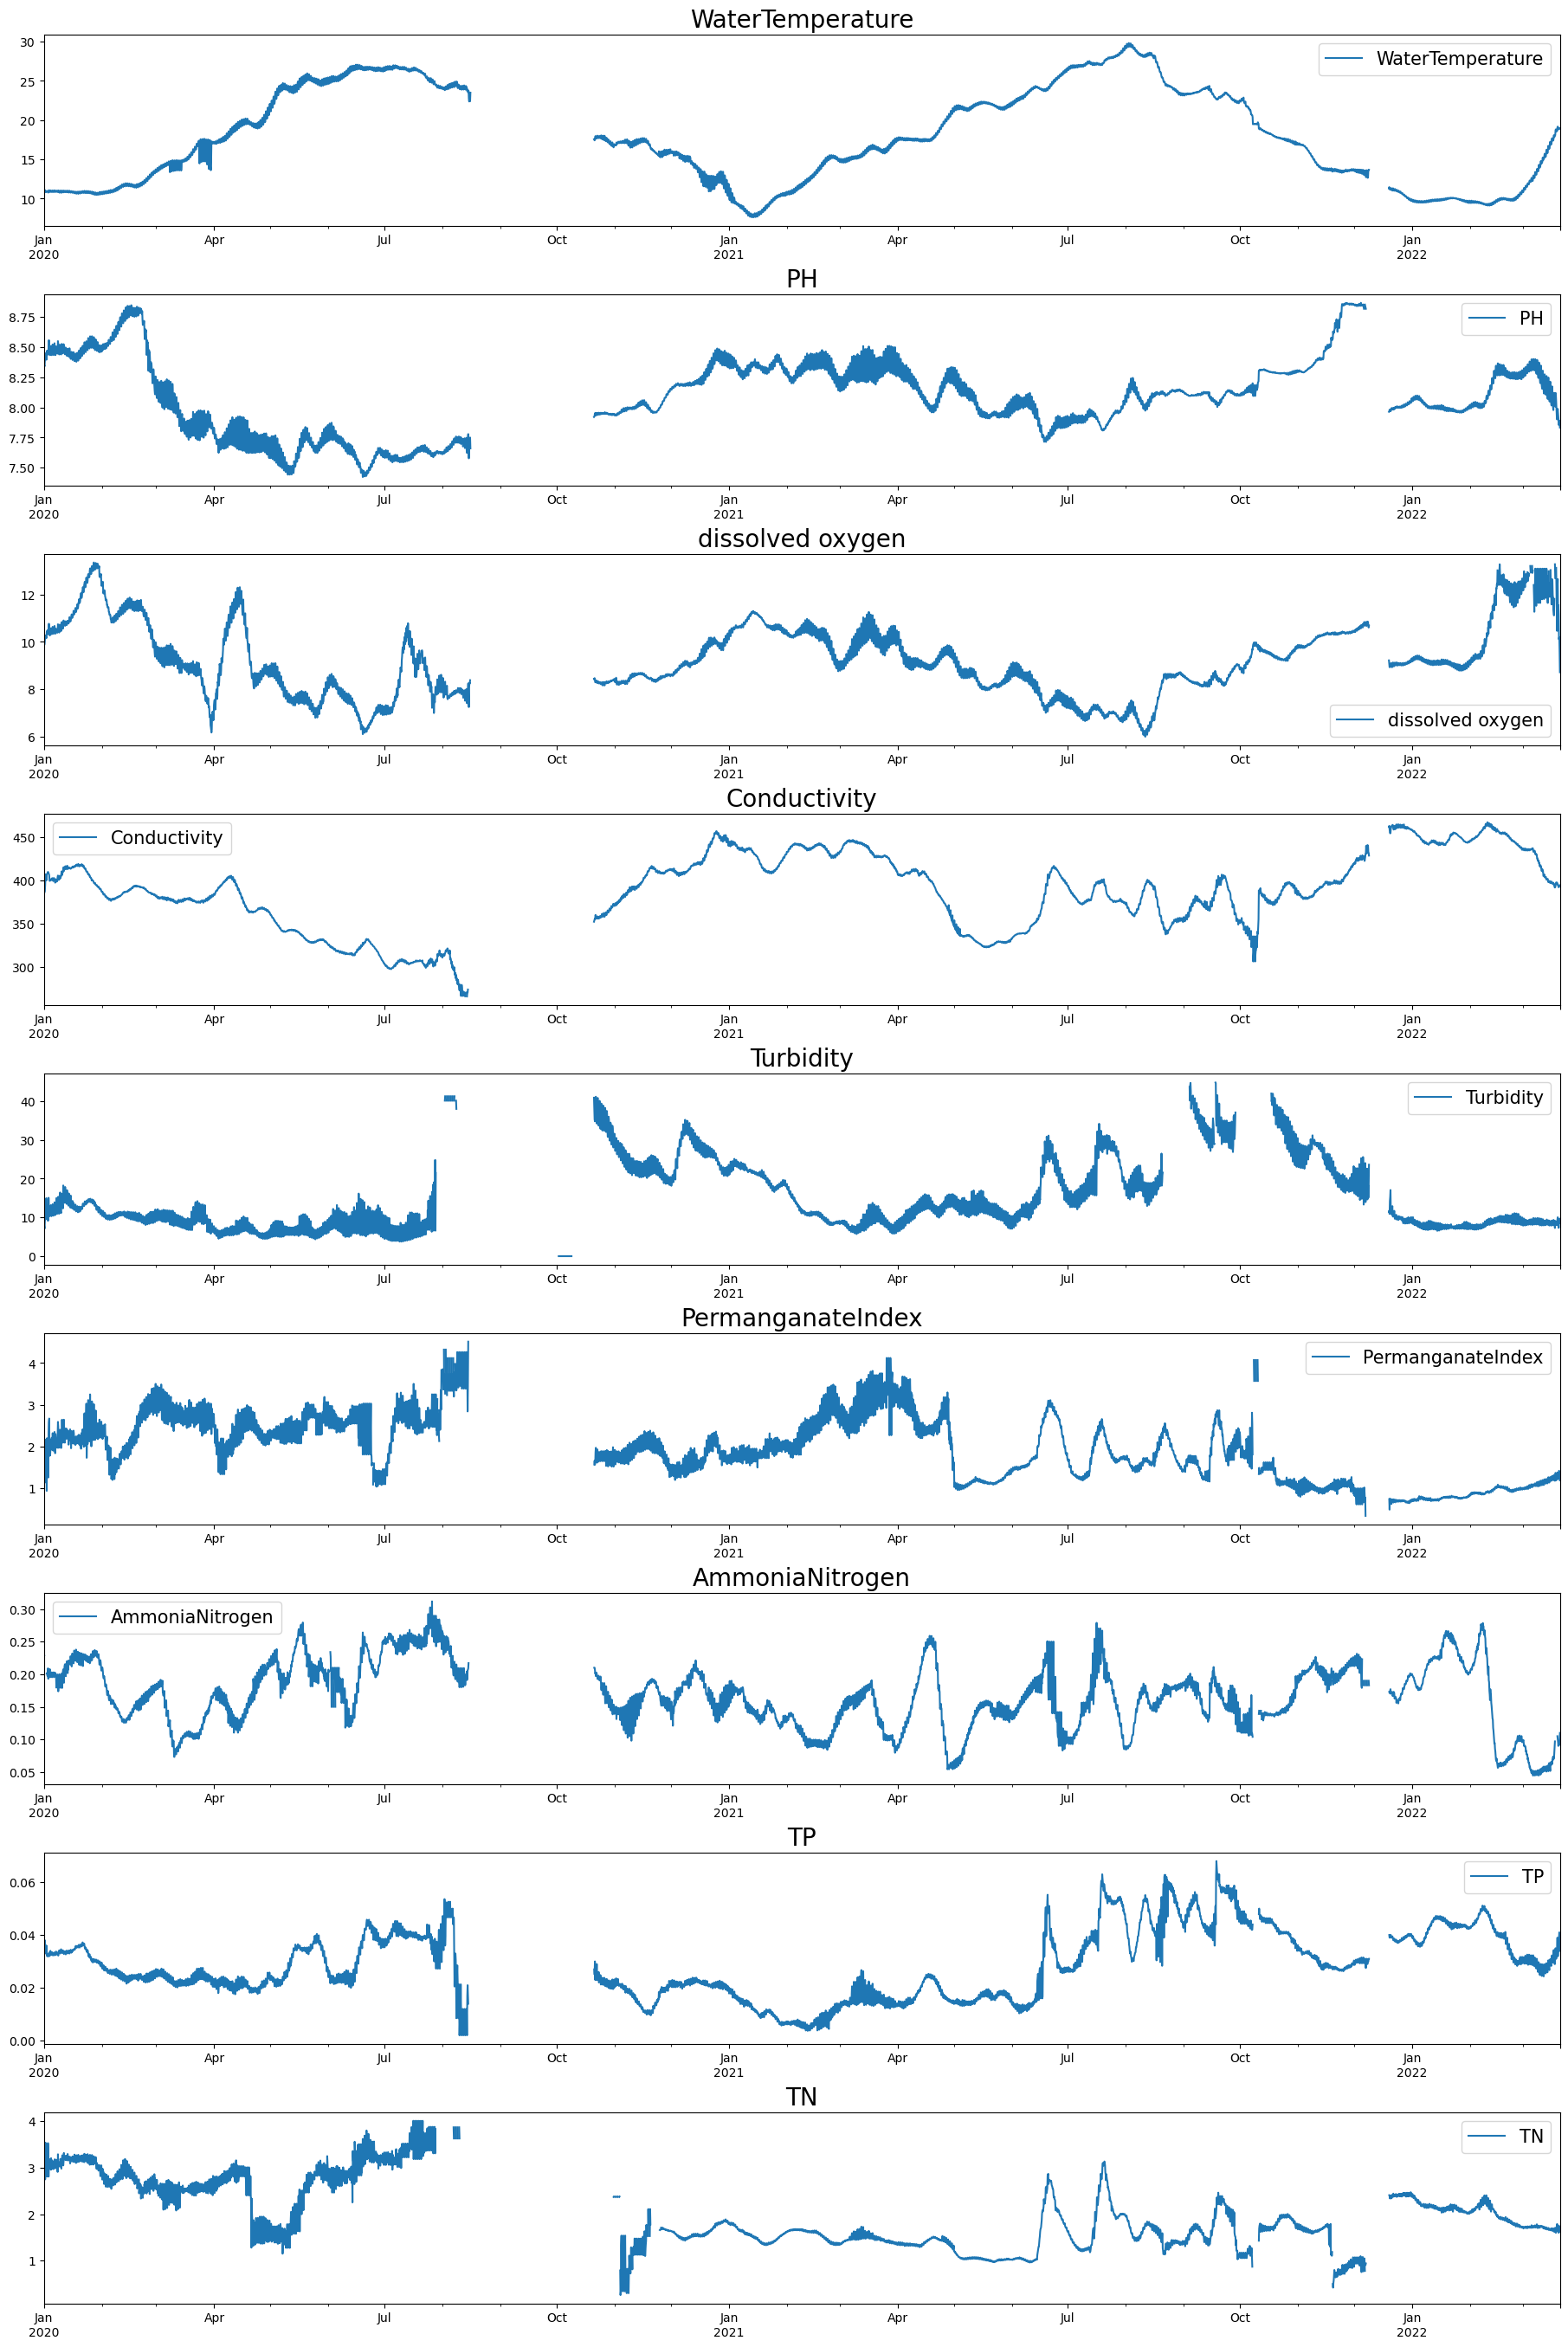

In [93]:
index_nums = len(df.keys())
print(df.keys())
l, h = 18, 3
fig, axis = plt.subplots(index_nums, 1, figsize=(l, h*index_nums), constrained_layout=True)
for i in range(index_nums):
    name = en_keys[i]
    df.plot(y=df.keys()[i], ax=axis[i])
    axis[i].set_title(name, fontsize=20)
    axis[i].set_xlabel('', fontsize=15)
    axis[i].set_ylabel('', fontsize=15)
    
    axis[i].legend([name], fontsize=15)

In [26]:
x=df.loc['2020-01-01 04:00:00']
x.isna().all()


False

In [69]:
df.index[3:-3]

DatetimeIndex(['2020-01-01 12:00:00', '2020-01-01 16:00:00',
               '2020-01-01 20:00:00', '2020-01-02 00:00:00',
               '2020-01-02 04:00:00', '2020-01-02 08:00:00',
               '2020-01-02 12:00:00', '2020-01-02 16:00:00',
               '2020-01-02 20:00:00', '2020-01-03 00:00:00',
               ...
               '2022-03-18 20:00:00', '2022-03-19 00:00:00',
               '2022-03-19 04:00:00', '2022-03-19 08:00:00',
               '2022-03-19 12:00:00', '2022-03-19 16:00:00',
               '2022-03-19 20:00:00', '2022-03-20 00:00:00',
               '2022-03-20 04:00:00', '2022-03-20 08:00:00'],
              dtype='datetime64[ns]', name='采集时间', length=4854, freq='4H')

In [73]:
def my_patch_up(df, r=3, delta=3):
    my_index=df.index[18:-18]
    step = 2 * r + 1
    group = df.groupby([df.index.hour])
    dfns = [pd.DataFrame(group.get_group(k)) for k in group.groups.keys()]
    dfns = [dfn.rolling(step, center=True, min_periods=1).mean() for dfn in dfns]
    for idx in my_index:
        k = idx.hour // 4
        if df.loc[idx].isna().all():
            a = []
            Rsum, Lsum = 0,0
            for i in range(delta):
                a += [df.loc[idx+timedelta(days=i+1)].isna().all(),
                              df.loc[idx-timedelta(days=i+1)].isna().all()]
            for i in range(delta):
                if a[2*i] == 1:
                    Rsum += 1
                else:
                    Rsum = 0
                    break
            for i in range(delta):
                if a[2*i+1] == 1:
                    Lsum += 1
                else:
                    Lsum = 0
                    break
            if Rsum+Lsum > 0:
                pass
            else:
                df.loc[idx] =  dfns[k].loc[str(idx.date())].values
                    
                
    for k in df.keys():
        for idx in my_index:
            hour = idx.hour // 4
            if df[k].loc[idx] == np.nan:
                a = []
            Rsum, Lsum = 0,0
            for i in range(delta):
                a += [df[k].loc[idx+timedelta(days=i+1)] == np.nan,
                              df[k].loc[idx-timedelta(days=i+1)] == np.nan]
            for i in range(delta):
                if a[2*i] == 1:
                    Rsum += 1
                else:
                    Rsum = 0
                    break
            for i in range(delta):
                if a[2*i+1] == 1:
                    Lsum += 1
                else:
                    Lsum = 0
                    break
            if Rsum+Lsum > 0:
                pass
            else:
                df[k].loc[idx] = dfns[hour][k].loc[str(idx.date())]
    return df
        
df=my_patch_up(df)
df
        

,水温,pH,溶解氧,电导率,浊度,高锰酸盐指数,氨氮,总磷,总氮
采集时间,,,,,,,,,
2020-01-01 00:00:00,10.875,8.3625,9.8975,386.150,7.800,0.91,0.230,0.038,NaN
2020-01-01 04:00:00,10.875,8.3500,9.8700,386.250,7.825,1.41,0.229,0.035,NaN
2020-01-01 08:00:00,10.875,8.3400,9.8950,386.025,7.100,1.13,NaN,0.036,NaN
2020-01-01 12:00:00,11.025,8.3875,10.0675,387.375,8.950,1.87,NaN,0.038,2.97
2020-01-01 16:00:00,11.075,8.4300,10.2175,394.225,11.725,1.36,NaN,0.036,2.75
...,...,...,...,...,...,...,...,...,...
2022-03-20 04:00:00,19.000,7.8950,11.1400,391.900,7.300,1.31,0.095,0.035,1.60
2022-03-20 08:00:00,18.925,7.8525,10.1025,392.375,9.500,1.42,0.091,0.039,1.75
2022-03-20 12:00:00,19.000,7.8900,10.2000,392.775,8.475,1.41,0.093,0.041,1.66


In [30]:
a=[True, False, True]
sum(a)

2

In [66]:
df.index.min()
#df.index.max()


Timestamp('2020-01-01 00:00:00', freq='4H')